## A notebook that runs UNet prediction in batches

by only loading the model once to the gpu prediction is much faster 

In [2]:
#import packages

import os
from datetime import datetime

import numpy as np
import os 
import argparse
import logging

import sys

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image



sys.path.insert(0,"./Pytorch-UNet/")
from utils.data_loading import BasicDataset
from unet import UNet
from utils.utils import plot_img_and_mask



In [3]:
# add relevant functions:

def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    return mask[0].long().squeeze().numpy()



def mask_to_image(mask: np.ndarray, mask_values):
    if isinstance(mask_values[0], list):
        out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
    elif mask_values == [0, 1]:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
    else:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

    if mask.ndim == 3:
        mask = np.argmax(mask, axis=0)

    for i, v in enumerate(mask_values):
        out[mask == i] = v

    return Image.fromarray(out)


In [3]:
#initialize cuda 

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # use GPU with index 1


In [4]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the default CUDA device
    device = torch.device("cuda")

    # Query the available memory
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    free_memory = total_memory - allocated_memory

    print(f"Total GPU Memory: {total_memory / 1024**2:.2f} MB")
    print(f"Allocated GPU Memory: {allocated_memory / 1024**2:.2f} MB")
    print(f"Free GPU Memory: {free_memory / 1024**2:.2f} MB")
else:
    print("CUDA is not available.")



Total GPU Memory: 2047.75 MB
Allocated GPU Memory: 0.00 MB
Free GPU Memory: 2047.75 MB


Specify input paramaters 

In [5]:
image_dir = '/home/lmeyers/paintDetect/images/testing/'
model = '/home/lmeyers/paintDetect/wandb/run-20230526_003438-r4vajhjg/files/20230526_004722_model.pth'

The below code will create a new timestamped directory in the mask folder where predictions will be saved. 
It wil then load the model to the gpu and call each file in the image_dir and save with a .pred.jpg 

In [6]:

current_date = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
directory_name = f"/home/lmeyers/paintDetect/data/thorax_only_masks/predict_{current_date}"
os.mkdir(directory_name)

#image_dir = "/home/lmeyers/paintDetect/images/testing/"


in_files = []
out_files = []

dir_list = os.walk(image_dir)
for root, dirs, files in dir_list:
    for f in files: 
        #print(root+f)
        in_files.append(root+f)
        out_files.append(f"/home/lmeyers/paintDetect/masks/predict_{current_date}/"+f[:-4]+'.Thorax.pred.jpg')


logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


#model = '/home/lmeyers/paintDetect/wandb/latest-run/files/20230525_113551_model.pth'

net = UNet(n_channels=3, n_classes=2, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {model}')
logging.info(f'Using device {device}')

net.to(device=device)
state_dict = torch.load(model, map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

logging.info('Model loaded!')

for i, filename in enumerate(in_files):
    logging.info(f'Predicting image {filename} ...')
    img = Image.open(filename)

    mask = predict_img(net=net,
                        full_img=img,
                        scale_factor=1,
                        out_threshold=.5,
                        device=device)

   
    out_filename = out_files[i]
    result = mask_to_image(mask, mask_values)
    result.save(out_filename)
    logging.info(f'Mask saved to {out_filename}')

INFO: Loading model /home/lmeyers/paintDetect/wandb/latest-run/files/20230525_113551_model.pth
INFO: Using device cuda
INFO: Model loaded!
INFO: Predicting image /home/lmeyers/paintDetect/images/testing/f13x2022_06_28.mp4.track000076.frame002641.jpg ...
INFO: Mask saved to /home/lmeyers/paintDetect/masks/predict_2023-05-25-12:02:04/f13x2022_06_28.mp4.track000076.frame002641.pred.jpg
INFO: Predicting image /home/lmeyers/paintDetect/images/testing/f2x2022_06_22.mp4.track000022.frame004129.jpg ...
INFO: Mask saved to /home/lmeyers/paintDetect/masks/predict_2023-05-25-12:02:04/f2x2022_06_22.mp4.track000022.frame004129.pred.jpg
INFO: Predicting image /home/lmeyers/paintDetect/images/testing/f08x2022_06_28.mp4.track000082.frame001515.jpg ...
INFO: Mask saved to /home/lmeyers/paintDetect/masks/predict_2023-05-25-12:02:04/f08x2022_06_28.mp4.track000082.frame001515.pred.jpg
INFO: Predicting image /home/lmeyers/paintDetect/images/testing/f10x2022_06_28.mp4.track000162.frame003997.jpg ...
INFO: M

INFO: Loading model /home/lqmeyers/paintDetect/wandb/run-20230612_144301-pboxk4b3/files/model.pth
INFO: Using device cuda
INFO: Model loaded!
INFO: Predicting image /home/lqmeyers/paintDetect/data/images/testing/f3.1x2022_06_22.mp4.track000093.frame007395.jpg ...
INFO: Mask saved to /home/lqmeyers/paintDetect/data/full_masks/f3.1x2022_06_22.mp4.track000093.frame007395.pred.jpg


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
predicted results for  /home/lqmeyers/paintDetect/data/images/testing/f3.1x2022_06_22.mp4.track000093.frame007395.jpg


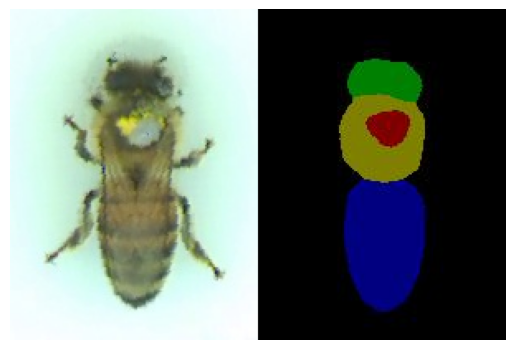

In [18]:
##predict on single image to test parameters:

#imports 
from PIL import Image
from matplotlib import pyplot as plt

#specify file to test prediction on
image_path= "/home/lqmeyers/paintDetect/data/images/testing/f3.1x2022_06_22.mp4.track000093.frame007395.jpg"
out_path="/home/lqmeyers/paintDetect/data/full_masks/f3.1x2022_06_22.mp4.track000093.frame007395.pred.jpg"


#initialize logging and run prediction--------

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
model = '/home/lqmeyers/paintDetect/wandb/run-20230612_144301-pboxk4b3/files/model.pth'

net = UNet(n_channels=3, n_classes=5, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {model}')
logging.info(f'Using device {device}')

net.to(device=device)
state_dict = torch.load(model, map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

logging.info('Model loaded!')
logging.info(f'Predicting image {image_path} ...')

img = Image.open(image_path)

mask = predict_img(net=net,
                    full_img=img,
                    scale_factor=1,
                    out_threshold=.5,
                    device=device)


out_filename = out_path

print(mask[55]) #array of class prediction
result = mask_to_image(mask, mask_values)
result.save(out_filename) #this is causing the problem!!!!!!!!!!!!!!!!!!!!!!!!!!!
logging.info(f'Mask saved to {out_filename}')

result = Image.open(out_filename)
#--------visualize results-------------

if  np.array(img).shape != np.array(result).shape:
    arr = np.array(result)
    arr_reshaped = np.expand_dims(arr, axis=-1)  # Add a new axis at the end
    arr_reshaped = np.tile(arr_reshaped, (1, 1, 3)) 
    if  np.array(img).shape != np.array(arr_reshaped).shape:
        print('check input image dimensions, remember to put binary masks second')
        pass
# Stitch the images horizontally
    stitched_image = np.concatenate((img, arr_reshaped), axis=1)
else:
    stitched_image = np.concatenate((img, result), axis=1)

# Display the stitched image
print("predicted results for ",image_path)

plt.imshow(stitched_image)
plt.axis('off')
plt.show()